class Particle3D():
    def __init__(self, system, spawn = False):
        '''
        Calls the spawn method
        Parameters:
        system is a reference to a list that contains information of all the particles and their coordinates
        '''
        self.mass = 1
        self.vdw = 1
        if spawn:
            self.Spawn()

    def Draw(self):
        '''
        draw the particle. returns none
        '''
        ax = fig.gca(projection='3d')
        ax.scatter(self.x, self.y, self.z, c = "black", s = 0.5)
        #ax.add_artist(plt.Circle((self.x, self.y), self.vdw, fill = False))
        #plt.axis([0, xlim, 0, ylim])
        #plt.axis('equal')
        
    
    def Check_VDW_Collision(self, particle, k = 1):
        '''
        Parameters: k is a scaling factor for collision
        returns True if there exists a particle within self's vdw radius
        '''
        return ((particle.x - self.x)**2 + (particle.y - self.y)**2 + (particle.z - self.z)**2)**(1/2) <= (self.vdw + particle.vdw)*k

    def Spawn(self):
        '''
        Attempts to generate valid x,y positions for itself. Uses system list to identify valid positions. If no valid position
        is found, the particle is garbage collected(?)

        Spawning will either no longer consider vdw radius or some fractional vdw radius if a decent equilibration method for the system is used
        '''
        global error_spawn_ct
        for attempt in range(N+50):
            self.x = rand.uniform(0, xlim)
            self.y = rand.uniform(0, ylim)
            self.z = rand.uniform(0, zlim)
            if not any((self.x, self.y, self.z) == (particle.x, particle.y, particle.z) or self.Check_VDW_Collision(particle) for particle in system):
                #if particle spawns on top of another one or it is too close to another particle then attempt a new spawn
                break

        else:
            #print("Molecule failed to spawn!")
            error_spawn_ct += 1
            return None #i think so long as system doesnt append the object when it fails to spawn, no reference therefore will be garbage collected??
        system.append(self)
        #print("Particle spawned!")

class Water():
    def __init__(self):
        #atom: [[connected to atom 2, connected to atom 3],[distance to atom 2, distance to atom 3], [angle to NEXT atom]]
        #initial coordinates
        self.xi = rand.uniform(xlim)
        self.yi = rand.uniform(ylim)
        self.zi = rand.uniform(zlim)
        matrix = OrderedDict({Particle3D: [[1],[0.96], [180]], Particle3D: [[0,2], [0.96, 0.96], [104.50]], Particle3D: [[1],[0.96], [180]]})

    
    def Draw(self):
        ax = fig.gca(projection='3d')
        for i,atom in enumerate(matrix.keys()):
            if i == 0:
                #the reference coordinate (randomized upon instantiation) is given to the first atom of the matrix.continue
                #then, the reference coordinate is changed by bond length of the next connected atom, and theta/phi is randomized
                ax.scatter(self.xi, self.yi, self.zi, c = "black", s = atom.vdw)
                coord[atom] = [xi, yi, zi]
                th = rand.random(0, 2*math.pi)
                phi = rand.random(0, 2*math.pi)
                r = matrix[atom][1]
                self.xi += r * math.cos(th) * math.sin(phi) #change the reference coordinates by some random theta and phi with experimental bond length
                self.yi += r * math.sin(th) * math.sin(phi)
                self.zi += r * math.cos(phi)
                continue
            #building on subsequent atoms
            

            

In [4]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
from tqdm import tnrange
from tqdm import trange

In [5]:
%matplotlib inline
from collections import OrderedDict
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import random as rand
import math
from math import exp
from mpl_toolkits.mplot3d import Axes3D as plt3d
import numpy as np
import time
#fig, ax = plt.subplots(figsize=(20,10))

In [6]:
#simulation parameters
xlim = 10 #angstrom
ylim = 10
zlim = 10
N = 3 #particles
error_spawn_ct = 0 #count of failed spawn
T = 300 #temperature, Kelvin
kb = 1.38064852e-23 #boltzmann constant J/K
B = (kb*T)**-1 #beta

In [7]:
def distance(atom1, atom2):
    #gives distance between atom
    return ((atom1.x - atom2.x)**2 + (atom1.y - atom2.y)**2)**(1/2)

class Ensemble():
    #basically a numpy array containing objects but with more functionalities
    def __init__(self):
        self.configuration = np.array([])
        self.configuration_total_energies = np.array([]) #during sampling, any accepted configuration will have its energy sotred in this list.
    
    def __getitem__(self, key):
        return self.configuration[key]
    
    def __setitem__(self, key, value):
        self.configuration[key] = value

    def append(self, value):
        self.configuration = np.append(self.configuration, value)

    def Calculate_VDW(self):
        #pairwise calculation & i != j
        for i in self.configuration:
            i.V = 0
            for j in self.configuration:
                if i == j:
                    continue
                d = distance(i, j)
                #Lorentz-Berthelot mixing rule
                si = (i.sigma + j.sigma)/2 
                ep = (i.epsilon * j.epsilon)**1/2
                i.V += (4 * ep * ((si/d)**12 - (si/d)**6)) #joules
    
    def Energy_Total(self):
        self.Calculate_VDW()
        return sum(atom.V for atom in self.configuration)
    
    def AcceptanceRule(self, Uo, Ut):
        #Canonical acceptance function
        try:
            return min(1, exp((-1)*B*(Ut - Uo)))
        except OverflowError:
            print("Overflow error! - Ensemble.AcceptanceRule()")
            return 1

    def Cycle(self):
        atom = self.configuration[rand.randint(0, len(self.configuration) - 1)] #in the current configuration (system), select a random atom
        #rigid translation
        low = -0.001
        high = 0.001
        xo = atom.x #old/current x of the selected atom
        yo = atom.y
        xt = atom.x + rand.uniform(low, high) #x trial
        yt = atom.x + rand.uniform(low, high) #y trial

        while True:
            while xt < 0 or xt > xlim:
                #print('2')
                xt = atom.x + rand.uniform(low, high)
                while any((xt, yt) == (particle.x, particle.y) for particle in self.configuration):
                    #print('1')
                    xt = atom.x + rand.uniform(low, high) #x trial
                    yt = atom.x + rand.uniform(low, high) #y trial
            #else:
                #print('2e')
                    
            while yt < 0 or yt > ylim:
                #print('3')
                yt = atom.x + rand.uniform(low, high)
                while any((xt, yt) == (particle.x, particle.y) for particle in self.configuration):
                    #print('1')
                    xt = atom.x + rand.uniform(low, high) #x trial
                    yt = atom.x + rand.uniform(low, high) #y trial
            #else:
                #print('3e')

            break
        
        Uo = self.Energy_Total() # Uo is total system of OLD/current configuration
        atom.x = xt #change atom coordinates to trial ones
        atom.y = yt
        Ut = self.Energy_Total()
        if rand.uniform(0,1) < self.AcceptanceRule(Uo, Ut):
            #accept Ut
            self.configuration_total_energies = np.append(self.configuration_total_energies, Ut)
            return
        else:
            #reject Ut
            atom.x = xo
            atom.y = yo
            self.configuration_total_energies = np.append(self.configuration_total_energies, Uo)


    def Average(self, configuration_energies):
        #takes in an array containing energies corresponding to a sampled configuration
        #evaluates average energy by probaility weighting
        numerator = 0
        denominator = 0
        for i in range(len(configuration_energies)):
            numerator += (configuration_energies[i] * exp((-1)*B*self.configuration_total_energies[i]))
            denominator += exp((-1)*B*self.configuration_total_energies[i])
        return numerator/denominator

        



class Particle():
    def __init__(self, ensemble):
        '''
        Calls the spawn method
        Parameters:
        ensemble is a reference to a list that contains information of all the particles and their coordinates
        '''
        self.mass = 1
        self.vdw = 0.38 #angstrom
        self.sigma = 2.782 #angstrom; Ramírez and Herrero: http://www.sklogwiki.org/SklogWiki/index.php/Neon
        self.epsilon = 5.1485944e-13 #joules
        self.V = 0
        self.Spawn()

    def Draw(self):
        '''
        draw the particle. returns none
        '''

        plt.scatter(self.x, self.y, c = "black", s = 1)
        ax.add_artist(plt.Circle((self.x, self.y), self.vdw, fill = False))
        plt.axis([0, xlim, 0, ylim])
        plt.axis('equal')
        
    
    def Check_VDW_Collision(self, particle, k = 1):
        '''
        Parameters: k is a scaling factor for collision
        returns True if there exists a particle within self's vdw radius
        '''
        return distance(self, particle) <= (self.vdw + particle.vdw)*k

    def Spawn(self):
        '''
        Attempts to generate valid x,y positions for itself. Uses ensemble list to identify valid positions. If no valid position
        is found, the particle is garbage collected(?)

        Spawning will either no longer consider vdw radius or some fractional vdw radius if a decent equilibration method for the ensemble is used
        '''
        global error_spawn_ct
        for attempt in range(N+50):
            self.x = rand.uniform(0, xlim)
            self.y = rand.uniform(0, ylim)
            if not any((self.x, self.y) == (particle.x, particle.y) or self.Check_VDW_Collision(particle) for particle in ensemble):
                #if particle spawns on top of another one or it is too close to another particle then attempt a new spawn
                break

        else:
            #print("Molecule failed to spawn!")
            error_spawn_ct += 1
            return None #i think so long as system doesnt append the object when it fails to spawn, no reference therefore will be garbage collected??
        ensemble.append(self)
        #print("Particle spawned!")

fig, ax = plt.subplots(figsize=(20,10))
plt.axis('off')
#plt.xlim(0, 100)
#plt.ylim(0, 100)
system = [] #list containing all obj

#randomly generate 50 particles

#if force field -> vdw; if electrostatics then must have charges. can do inert gases (vdw only). or just use partition fnctions to get average energies for each molecule
for i in range(N):
    Particle(system)

for particle in system:
    particle.Draw()

print("Failed to spawn:", error_spawn_ct)
print("Spawned:", N-error_spawn_ct)

fig = plt.figure()
fig, ax = plt.subplots(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.grid(True)
ax.scatter(1,2,3)

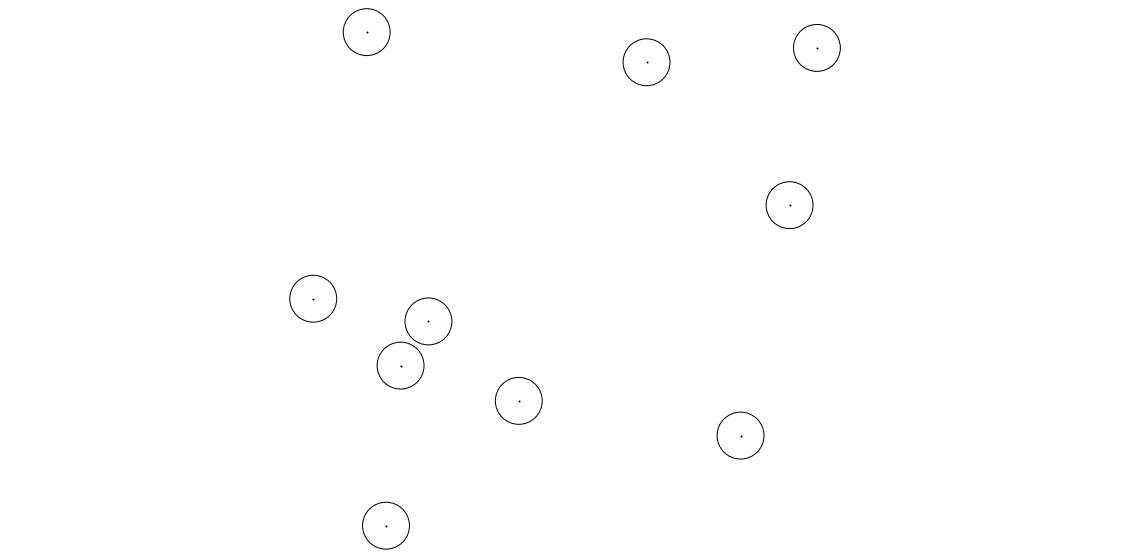

In [5]:
fig, ax = plt.subplots(figsize=(20,10))
plt.axis('off')
plt.xlim(0, 100)
plt.ylim(0, 100)


ensemble = Ensemble()
N = 10
for i in range(N):
    Particle(ensemble)
for particle in ensemble:
    particle.Draw()

100%|██████████| 1000000/1000000 [1:18:08<00:00, 213.27it/s]


Initial: 1.6914939868275361e-18 Joules
Final: 2.0085058468003923e-20 Joules
Elapsed time (simulation): 4688.824090003967
Ensemble Average: 1.5158280828833766e-20 Joules
Elapsed time (averaging): 1.8153250217437744


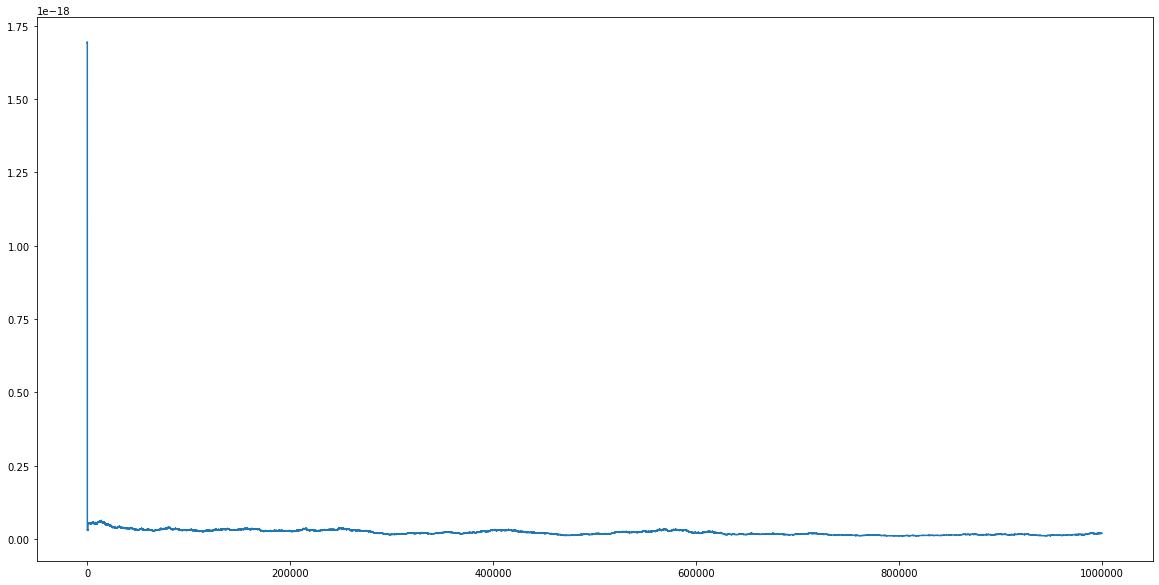

In [6]:
#ensemble = Ensemble()
#N = 30
#for i in range(N):
#    Particle(ensemble)
ncyc =1000000
y = [ensemble.Energy_Total()]
start_time = time.time()


for i in trange(ncyc):
    #print(i)
    ensemble.Cycle()
    y.append(ensemble.Energy_Total()) m

    
elapsed_time = time.time() - start_time
print("Initial:", y[0], "Joules")
print("Final:", y[-1], "Joules")
print("Elapsed time (simulation):", elapsed_time)
start_time = time.time()
print("Ensemble Average:", ensemble.Average(ensemble.configuration_total_energies), "Joules")
elapsed_time = time.time() - start_time
print("Elapsed time (averaging):", elapsed_time)

x = range(0, len(y))

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(x,y)

NameError: name 'ensemble' is not defined

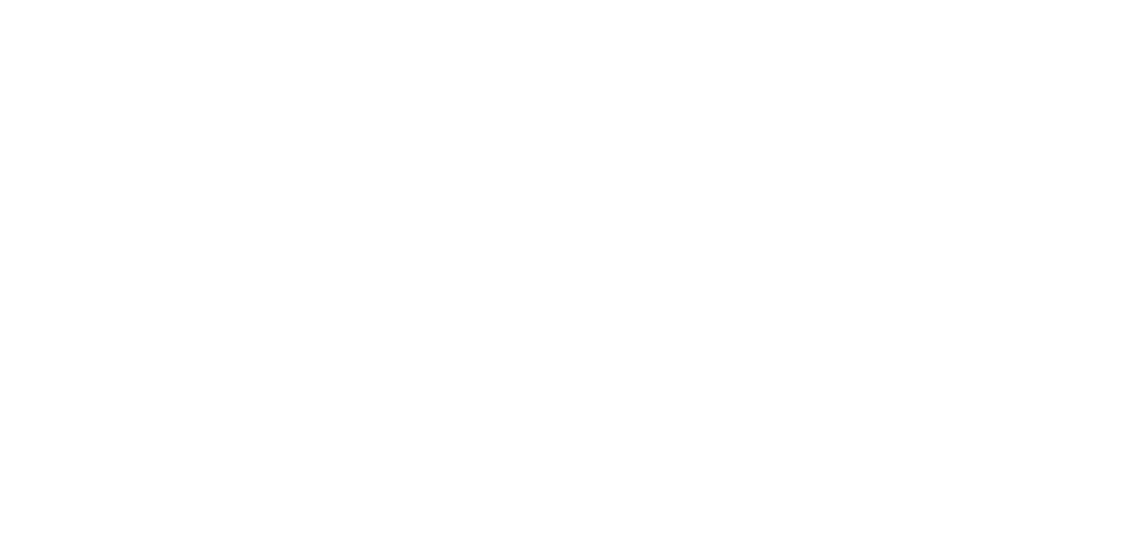

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
plt.axis('off')
plt.xlim(0, 100)
plt.ylim(0, 100)
for particle in ensemble:
    particle.Draw()

In [ ]:
my_list = list(range(100))
for x in tqdm(my_list):
    x+=1